In [1]:
# Settings
SPLIT = -1
NUM_OF_CLASSES = 35

# Hyperparams
BATCH_SIZE = 8
LEARNING_RATE = 0.00001

In [2]:
# Load Images
from pickle import load

files = "Processed Data/images_"
train = load(open(files + "train_%d.pickle" % SPLIT, "rb"))
# test = load(open(files + "test_%d.pickle" % SPLIT, "rb")) This should probably be loaded later
val = load(open(files + "val_%d.pickle" % SPLIT, "rb"))

In [3]:
# Load Ontology
import pandas as pd

ontology = pd.read_csv("Rellis-3D/ontology.csv")[["class_name", "output_value", "display_color"]].values.tolist()
colors = {v[0]: v[2] for v in ontology}
ontology = {v[0]: v[1] for v in ontology}

# Remove extra classes
del ontology["void"]
del ontology["dirt"]
del ontology["uphill"]
del ontology["downhill"]

# Process colors
colors = {c: (int(colors[c][1:3], 16), int(colors[c][3:5], 16), int(colors[c][5:7], 16)) for c in ontology.keys()}

# Convert ontology to color map
ontology = list(ontology.values())
ontology = [i in ontology for i in range(NUM_OF_CLASSES)]
    
NUM_OF_CLASSES = ontology.count(True)

In [4]:
# Preprocess Images
import numpy as np
from multiprocessing import Pool


def pre_process_images(img):
    return (img[0].astype(np.float16)/255, img[1][:, :, ontology])

def split_x_y(data):
    x_data = np.array([s[0] for s in data]).reshape((len(data),) + data[0][0].shape)
    y_data = np.array([s[1] for s in data]).reshape((len(data),) + data[0][1].shape)
    return x_data, y_data

# Normalize images
with Pool(64) as p:
    train = p.map(pre_process_images, train)
    val = p.map(pre_process_images, val)

x_train, y_train = split_x_y(train)
del train

x_val, y_val = split_x_y(val)
del val

In [5]:
import tensorflow as tf

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

2023-02-10 14:41:04.968584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 14:41:05.165381: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-10 14:41:06.016392: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ian/miniconda3/envs/tf/lib/
2023-02-10 14:41:06.016706: W tensorflow/compiler/xl

In [ ]:
# Create model
from tensorflow.keras import models, layers, optimizers, metrics

basic_segmenter = models.Sequential()
basic_segmenter.add(layers.Input(shape=x_train[0].shape))
basic_segmenter.add(layers.Conv2D(16, 3, activation="elu", padding="same"))
basic_segmenter.add(layers.Conv2D(16, 3, activation="elu", padding="same"))
basic_segmenter.add(layers.Conv2D(16, 3, activation="elu", padding="same"))
basic_segmenter.add(layers.MaxPool2D(2))
basic_segmenter.add(layers.Conv2D(32, 3, activation="elu", padding="same"))
basic_segmenter.add(layers.Conv2D(32, 3, activation="elu", padding="same"))
basic_segmenter.add(layers.Conv2D(32, 3, activation="elu", padding="same"))
basic_segmenter.add(layers.MaxPool2D(2))
basic_segmenter.add(layers.Conv2D(64, 3, activation="elu", padding="same"))
basic_segmenter.add(layers.Conv2D(64, 3, activation="elu", padding="same"))
basic_segmenter.add(layers.Conv2D(64, 3, activation="elu", padding="same"))
basic_segmenter.add(layers.Conv2DTranspose((64 + NUM_OF_CLASSES) // 2, 3, strides=2, activation="elu", padding="same"))
basic_segmenter.add(layers.Conv2DTranspose(NUM_OF_CLASSES, 3, strides=2, activation="softmax", padding="same"))

# basic_segmenter.add(layers.Conv2DTranspose(NUM_OF_CLASSES, 5, strides=2, activation="elu", padding="same"))
# basic_segmenter.add(layers.Reshape((x_train[0].shape[0] * x_train[0].shape[1] * NUM_OF_CLASSES,)))
# basic_segmenter.add(layers.Dense(x_train[0].shape[0] * x_train[0].shape[1] * NUM_OF_CLASSES, activation="elu"))
# basic_segmenter.add(layers.Reshape((x_train[0].shape[0], x_train[0].shape[1], NUM_OF_CLASSES)))
# basic_segmenter.add(layers.Softmax())

opt = optimizers.Adam(learning_rate=LEARNING_RATE)

model_metrics = [
    metrics.TopKCategoricalAccuracy(k=1, name='Top 1 Accuracy'),
    metrics.TopKCategoricalAccuracy(k=3, name='Top 3 Accuracy'),
    metrics.TopKCategoricalAccuracy(k=5, name='Top 5 Accuracy'),
    metrics.MeanIoU(num_classes=NUM_OF_CLASSES, sparse_y_true=False, sparse_y_pred=False)
]

basic_segmenter.compile(opt, loss="categorical_crossentropy", metrics=model_metrics)
basic_segmenter.summary()

2023-02-21 00:49:22.735727: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 00:49:22.891457: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-21 00:49:23.523393: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ian/miniconda3/envs/tf/lib/
2023-02-21 00:49:23.523451: W tensorflow/compiler/xl

In [7]:
# This class streams data to the model
# https://stackoverflow.com/a/71592809
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train = DataGenerator(x_train, y_train, BATCH_SIZE)
val = DataGenerator(x_val, y_val, BATCH_SIZE)

In [8]:
# Fit model
from tensorflow.keras.callbacks import EarlyStopping

basic_segmenter.fit(
    train,
    batch_size = BATCH_SIZE,
    epochs = 100,
    callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    validation_data = val,
    validation_batch_size = BATCH_SIZE
)

Epoch 1/100


2023-02-10 14:41:12.034194: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201
2023-02-10 14:41:13.323146: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-10 14:41:16.958566: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1dafa830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-10 14:41:16.958590: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-02-10 14:41:16.973350: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-10 14:41:17.114444: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-10 14:41:17.167404: I tensorflow/compiler/jit/xla_compilation_c

100/100 [==============================] - 81s 698ms/step - loss: 2.8342 - Top 1 Accuracy: 0.1077 - Top 3 Accuracy: 0.3172 - Top 5 Accuracy: 0.4898 - mean_io_u: 0.0190 - val_loss: 2.7569 - val_Top 1 Accuracy: 0.1499 - val_Top 3 Accuracy: 0.3865 - val_Top 5 Accuracy: 0.6179 - val_mean_io_u: 0.0205
Epoch 2/100
100/100 [==============================] - 70s 693ms/step - loss: 2.4871 - Top 1 Accuracy: 0.2195 - Top 3 Accuracy: 0.5204 - Top 5 Accuracy: 0.7190 - mean_io_u: 0.0257 - val_loss: 2.2636 - val_Top 1 Accuracy: 0.2706 - val_Top 3 Accuracy: 0.6145 - val_Top 5 Accuracy: 0.7628 - val_mean_io_u: 0.0286
Epoch 3/100
100/100 [==============================] - 69s 691ms/step - loss: 1.9850 - Top 1 Accuracy: 0.3142 - Top 3 Accuracy: 0.7066 - Top 5 Accuracy: 0.8329 - mean_io_u: 0.0267 - val_loss: 1.8862 - val_Top 1 Accuracy: 0.3103 - val_Top 3 Accuracy: 0.7338 - val_Top 5 Accuracy: 0.8828 - val_mean_io_u: 0.0304
Epoch 4/100
100/100 [==============================] - 68s 682ms/step - loss: 1.74

In [9]:
# Load test set
test = load(open(files + "test_%d.pickle" % SPLIT, "rb"))

# Normalize images
with Pool(64) as p:
    test = p.map(pre_process_images, test)

x_test, y_test = split_x_y(test)
del test

# Create sequence
test = DataGenerator(x_test, y_test, BATCH_SIZE)

In [10]:
# Calculate metrics on the test set # top 1 .54
y_pred = basic_segmenter.evaluate(test)

# Latest run: loss: 1.3452 - Top 1 Accuracy: 0.5962 - Top 3 Accuracy: 0.8869 - Top 5 Accuracy: 0.9808 - mean_io_u_3: 0.1343

40/40 [==============================] - 15s 368ms/step - loss: 0.8593 - Top 1 Accuracy: 0.7232 - Top 3 Accuracy: 0.9384 - Top 5 Accuracy: 0.9727 - mean_io_u: 0.1222


1/1 [==============================] - 2s 2s/step


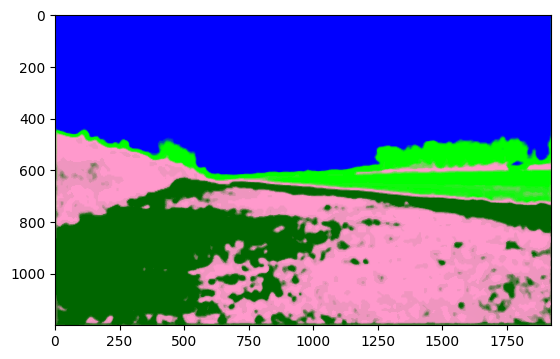

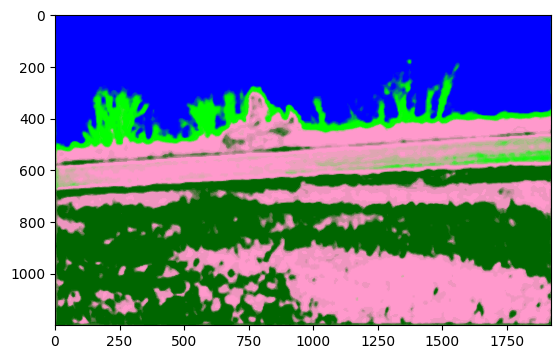

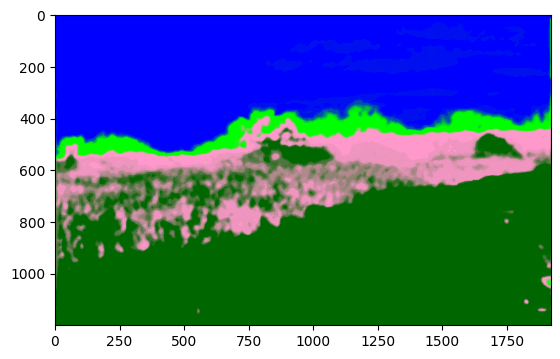

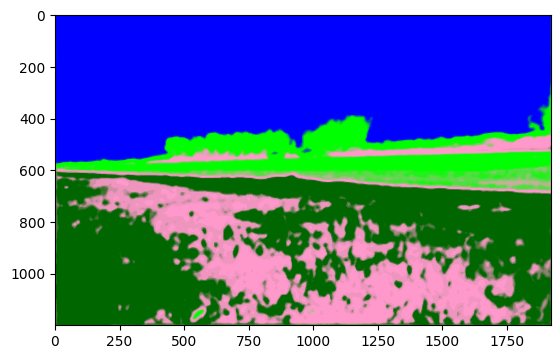

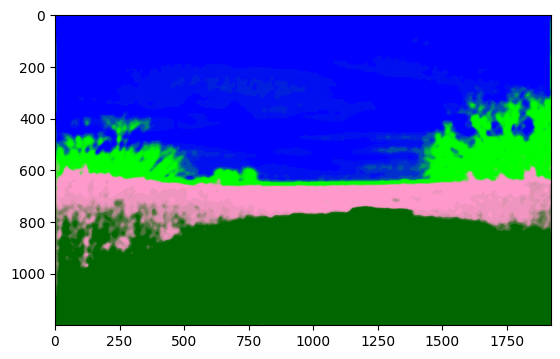

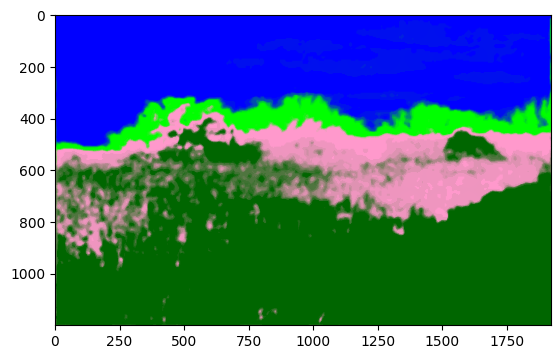

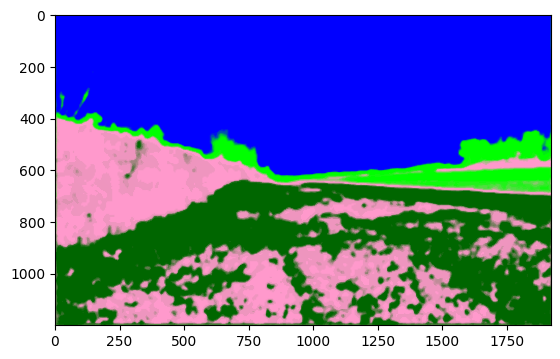

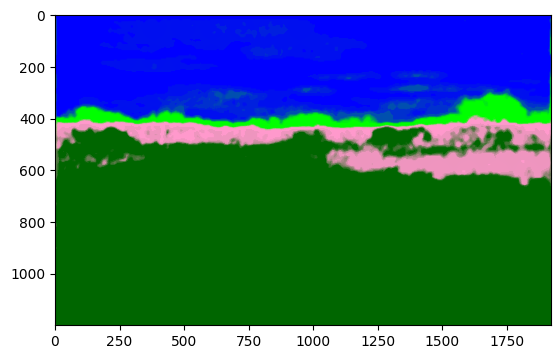

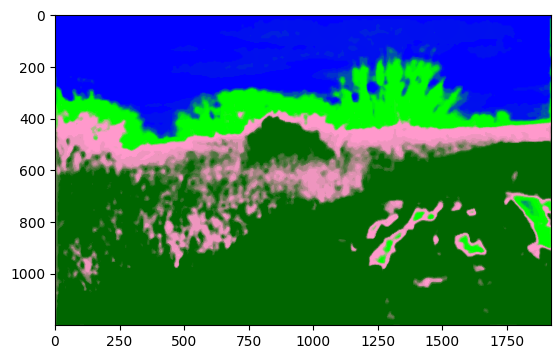

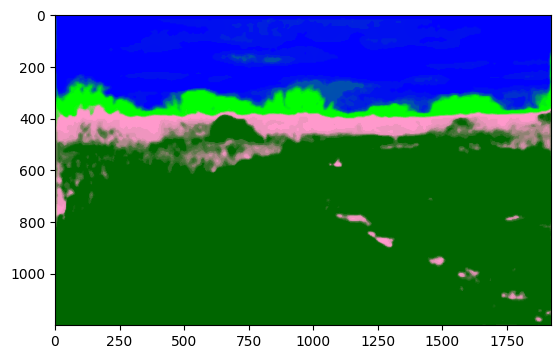

In [11]:
# Display 5 test images
import matplotlib.pyplot as plt

for image in basic_segmenter.predict(x_test[0:10, :, :]):
    colored_image = np.argmax(image, axis=-1)
    colored_image = np.array(list(colors.values()))[colored_image]
    plt.imshow(colored_image)
    plt.show()